In [16]:
#________________________Import
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.ticker as mtick
import datetime
import yfinance as yf
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
import copy
# Import de la librairie pypfopt qui sert à faire de l'optimisation de portefeuille
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
from pypfopt import plotting

In [17]:
# On charge une base de données contenant les tickers actions de Yahoo Finance téléchargée à partir du site suivant : https://investexcel.net/all-yahoo-finance-stock-tickers/
# La base de données datant de 2017, il est possible que certaines actions aient été retirées de la cotation (acquisition, fusion, faillite, changement de nom/ticker)
tickers_data = pd.read_excel("data/Yahoo Ticker Symbols.xlsx", sheet_name= "Stock")

# Le nombre de sociétés cotées étant large (+10 000 sociétés), nous allons optimiser le portefeuille uniquement sur 100 sociétés cotées à la bourse de New-York
tickers_data = tickers_data.loc[tickers_data["Exchange"]=="NYQ"]
# On supprime les sociétés en doublon. En effet, une société peut avoir 2 tickers différents (en raison de différentes classes d'actions)
tickers_data.drop_duplicates(subset='Name', keep="first")

,Ticker,Name,Exchange,Category Name,Country
2,BAC,Bank of America Corporation,NYQ,Money Center Banks,USA
4,T,AT&T Inc.,NYQ,Telecom Services - Domestic,USA
6,MO,"Altria Group, Inc.",NYQ,Cigarettes,USA
7,DAL,"Delta Air Lines, Inc.",NYQ,Major Airlines,USA
8,AA,Alcoa Corporation,NYQ,Aluminum,USA
...,...,...,...,...,...
104671,GRP-UN,GRANITE REAL ESTATE INVESTMENT,NYQ,NaN,USA
104863,INF-RW,INF-RW,NYQ,NaN,USA
104956,INST,"Instructure, Inc.",NYQ,NaN,USA
105466,MET-PBCL,MET-PBCL,NYQ,NaN,USA


In [18]:
# On génère une liste de 100 sociétés aléatoirement
tickers_data = tickers_data.sample(n=100)
tickers_data

# On met les tickers de ces sociétés sous forme de listes
symbols = list(tickers_data["Ticker"])

In [19]:
# on crée un dictionnaire qui associe les sociétés à leur industrie 
sector_mapper = dict(zip((list(tickers_data["Name"])), list(tickers_data["Category Name"])))
sector_mapper

# on crée un dictionnaire qui associe les société à leur pays d'origine
country_mapper = dict(zip((list(tickers_data["Name"])), list(tickers_data["Country"])))
country_mapper

{'STAG Industrial, Inc.': 'USA',
 'Community Health Systems, Inc.': 'USA',
 'Consumers Energy Company': 'USA',
 'The Goldman Sachs Group, Inc.': 'USA',
 'Pier 1 Imports, Inc.': 'USA',
 'New Residential Investment Corp.': 'USA',
 'Meritage Homes Corporation': 'USA',
 'BlackRock, Inc.': 'USA',
 'Southcross Energy Partners, L.P.': 'USA',
 'Norcraft Companies, Inc.': 'USA',
 'Radian Group Inc.': 'USA',
 'China Cord Blood Corporation': 'USA',
 'Diana Shipping Inc.': 'USA',
 'Franklin Universal Trust': 'USA',
 'Tsakos Energy Navigation Limited': 'USA',
 'PIMCO Strategic Income Fund, Inc.': 'USA',
 "Alexander's, Inc.": 'USA',
 'MSC Industrial Direct Co., Inc.': 'USA',
 'Corporate Backed Callable Trust Certificates, J.C. Penny Debenture-Backed Series 2007-1 Trust': 'USA',
 'Eaton Vance Corp.': 'USA',
 'Voya Infrastructure, Industrials and Materials Fund': 'USA',
 'TriNet Group, Inc.': 'USA',
 'Six Flags Entertainment Corporation': 'USA',
 'Prudential Short Duration High Yield Fund, Inc.': 'USA

In [20]:

# On crée une liste comprenant les tickers des sociétés que l'on souhaite analyser et on choisi la période 
symbols= list(tickers_data["Ticker"])
start="2020-01-01"
end="2022-12-31"

# Import de données et conservation uniquement des prix à la cloture
data = yf.download(symbols, start = start, end = end)
prices = data["Close"]
# On supprime les sociétés qui ne sont plus cotées et on rempli les jours de non cotation par les prix du dernier jour ouvré
prices = prices.dropna(axis=1, how='all')
prices = prices.fillna(method='ffill')




prices


Got error from yahoo api for ticker NRZ, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
[**                     4%                       ]  4 of 100 completedGot error from yahoo api for ticker PIR, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
[***                    7%                       ]  7 of 100 completedGot error from yahoo api for ticker RTN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
[*****                 11%                       ]  11 of 100 completedGot error from yahoo api for ticker RAS-PC, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
[*******               14%                       ]  14 of 100 completedGot error from yahoo api for ticker COR-PA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
[********              16%                       ]  16 of 100 completedGot error f

,ABR,ACN,ALK,ALX,AN,AXON,BAM,BBN,BGX,BLK,...,SIX,STNG,TAP,TDY,TNET,TRW,VAC,VVC,VZA,WIW
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,14.13,210.149994,68.169998,328.519989,48.919998,76.559998,NaN,24.670000,15.67,508.980011,...,45.060001,39.689999,53.540001,357.489990,57.169998,NaN,129.229996,0.04,25.549999,11.58
2020-01-03,14.19,209.800003,66.919998,332.609985,48.040001,73.930000,NaN,24.690001,15.58,503.570007,...,45.259998,39.419998,53.380001,360.049988,56.470001,49.990002,127.650002,0.04,25.549999,11.62
2020-01-06,14.20,208.429993,66.599998,337.470001,47.220001,68.750000,NaN,24.700001,15.39,504.000000,...,44.369999,38.630001,54.630001,358.630005,56.880001,49.990002,127.949997,0.04,25.549999,11.60
2020-01-07,14.24,203.929993,66.180000,327.359985,46.470001,69.769997,NaN,24.650000,15.56,507.220001,...,44.419998,39.080002,54.490002,361.089996,56.139999,47.049999,127.279999,0.04,25.549999,11.63
2020-01-08,14.41,204.330002,66.500000,330.899994,46.160000,69.610001,NaN,24.730000,15.61,507.100006,...,43.560001,36.840000,55.020000,361.549988,55.650002,47.080002,128.270004,0.04,25.549999,11.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,13.70,266.089996,43.310001,217.460007,107.139999,168.979996,28.040001,17.520000,10.86,703.940002,...,23.080000,54.720001,51.930000,393.750000,65.410004,62.169998,134.119995,0.06,25.549999,9.26
2022-12-27,13.59,265.309998,42.259998,219.570007,107.000000,166.250000,28.940001,16.950001,10.73,703.260010,...,22.850000,54.349998,52.330002,397.029999,66.320000,62.169998,134.259995,0.06,25.549999,9.18
2022-12-28,13.15,263.119995,41.299999,217.360001,105.750000,165.100006,28.139999,16.900000,10.67,700.330017,...,22.670000,52.689999,51.380001,390.690002,65.980003,62.169998,130.500000,0.06,25.549999,9.12


In [21]:
benchmark_prices

,Close
Date,
2020-01-02,324.869995
2020-01-03,322.410004
2020-01-06,323.640015
2020-01-07,322.730011
2020-01-08,324.450012
...,...
2022-12-23,382.910004
2022-12-27,381.399994
2022-12-28,376.660004


In [22]:
def daily_returns (df):

#Si des poids son définis 
    try :
        weights = optimized_allocation['1'].tolist()
        # on multiplie les prix par les poids pour avoir une valeur unvestie par action
        df_portfolio_prices_weighted = df*weights
        # Forward filling et before filling appliqués pour gérer les trous 
        df_portfolio_prices_weighted = df_portfolio_prices_weighted.fillna(method="ffill")
        df_portfolio_prices_weighted = df_portfolio_prices_weighted.fillna(method="bfill")
        # On somme le montant engagé dans chaque action pour avoir la valeur liquidative du portefeuille
        df_portfolio_daily_value = df_portfolio_prices_weighted.sum(axis=1)
        # retours entre 2 jours 
        df_portfolio_daily_returns= (df_portfolio_daily_value/df_portfolio_daily_value.shift(1) -1)*100
    except :
        # dans le cas d'un benchmark on utilise uniquement les prix entre 2 jours
        df = df.fillna(method="ffill")
        df = df.fillna(method="bfill")
        df_portfolio_daily_value = df.sum(axis=1)
        df_portfolio_daily_returns= (df_portfolio_daily_value/df_portfolio_daily_value.shift(1) -1)*100
    return df_portfolio_daily_returns


In [23]:
def optimizor (df_universe_prices, **kwargs) :
    # Calcul de l'espérance des retours de chaque action (estimée par la moyenne) ainsi que la covariance des retours journaliers de l'échantillon
    mu = expected_returns.mean_historical_return(df_universe_prices)
    S = risk_models.sample_cov(df_universe_prices)


    # Optimisation du portefeuille à partir de la librairie pypfopt 
    ef = EfficientFrontier(mu, S, weight_bounds=(0,0.05))

    # Ajout de contraintes sectorielle et géogrpahique 
    #ef.add_sector_constraints(sector_mapper, Sector_lower, Sector_upper)
    #ef.add_sector_constraints(country_mapper, Country_lower, Country_upper)
    ef.add_objective(objective_functions.L2_reg, gamma=0.03)
    #ef.min_volatility()
    
    ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    #ef.efficient_risk(target_volatility=0.2)
    #raw_weights = ef.max_sharpe()
    #ef.save_weights_to_file("weights.csv")  # saves to file
    print(cleaned_weights)
    ef.portfolio_performance(verbose=True)
    optimized_allocation = pd.DataFrame(cleaned_weights.items())

    return optimized_allocation

In [24]:
optimizor (df_universe_prices = prices)

/opt/anaconda3/lib/python3.9/site-packages/pypfopt/risk_models.py:68: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('ABR', 0.0), ('ACN', 0.05), ('ALK', 0.0), ('ALX', 0.0), ('AN', 0.05), ('AXON', 0.05), ('BAM', 0.0), ('BBN', 0.0), ('BGX', 0.0), ('BLK', 0.05), ('CCE', 0.0), ('CEM', 0.0), ('CIB', 0.0), ('CMS-PB', 0.0), ('CO', 0.0), ('CYH', 0.01085), ('EIX', 0.0), ('FDP', 0.0), ('FPF', 0.0), ('FRT', 0.0), ('FT', 0.0), ('GPI', 0.05), ('GS', 0.05), ('GTN', 0.0), ('HCI', 0.0), ('HPS', 0.0), ('HUBS', 0.05), ('IDE', 0.0), ('IR', 0.05), ('ISD', 0.0), ('ISP', 0.05), ('KAMN', 0.0), ('KFS', 0.05), ('KMI', 0.0), ('KNX', 0.05), ('KS', 0.0), ('MFV', 0.0), ('MHI', 0.0), ('MSM', 0.00793), ('MTH', 0.03669), ('NEE-PP', 0.05), ('NPV', 0.0), ('NX', 0.05), ('OGE', 0.0), ('PRTY', 0.0), ('RCS', 0.0), ('RDN', 0.0), ('REG', 0.0), ('SCHW', 0.05), ('SEE', 0.05), ('SIX', 0.0), ('STNG', 0.05), ('TAP', 0.0), ('TDY', 0.0), ('TNET', 0.0), ('TRW', 0.05), ('VAC', 0.0), ('VVC', 0.04453), ('VZA', 0.05), ('WIW', 0.0)])
Expected annual return: 15.5%
Annual volatility: 25.4%
Sharpe Ratio: 0.53


,0,1
0,ABR,0.00000
1,ACN,0.05000
2,ALK,0.00000
3,ALX,0.00000
4,AN,0.05000
5,AXON,0.05000
6,BAM,0.00000
7,BBN,0.00000
8,BGX,0.00000
9,BLK,0.05000


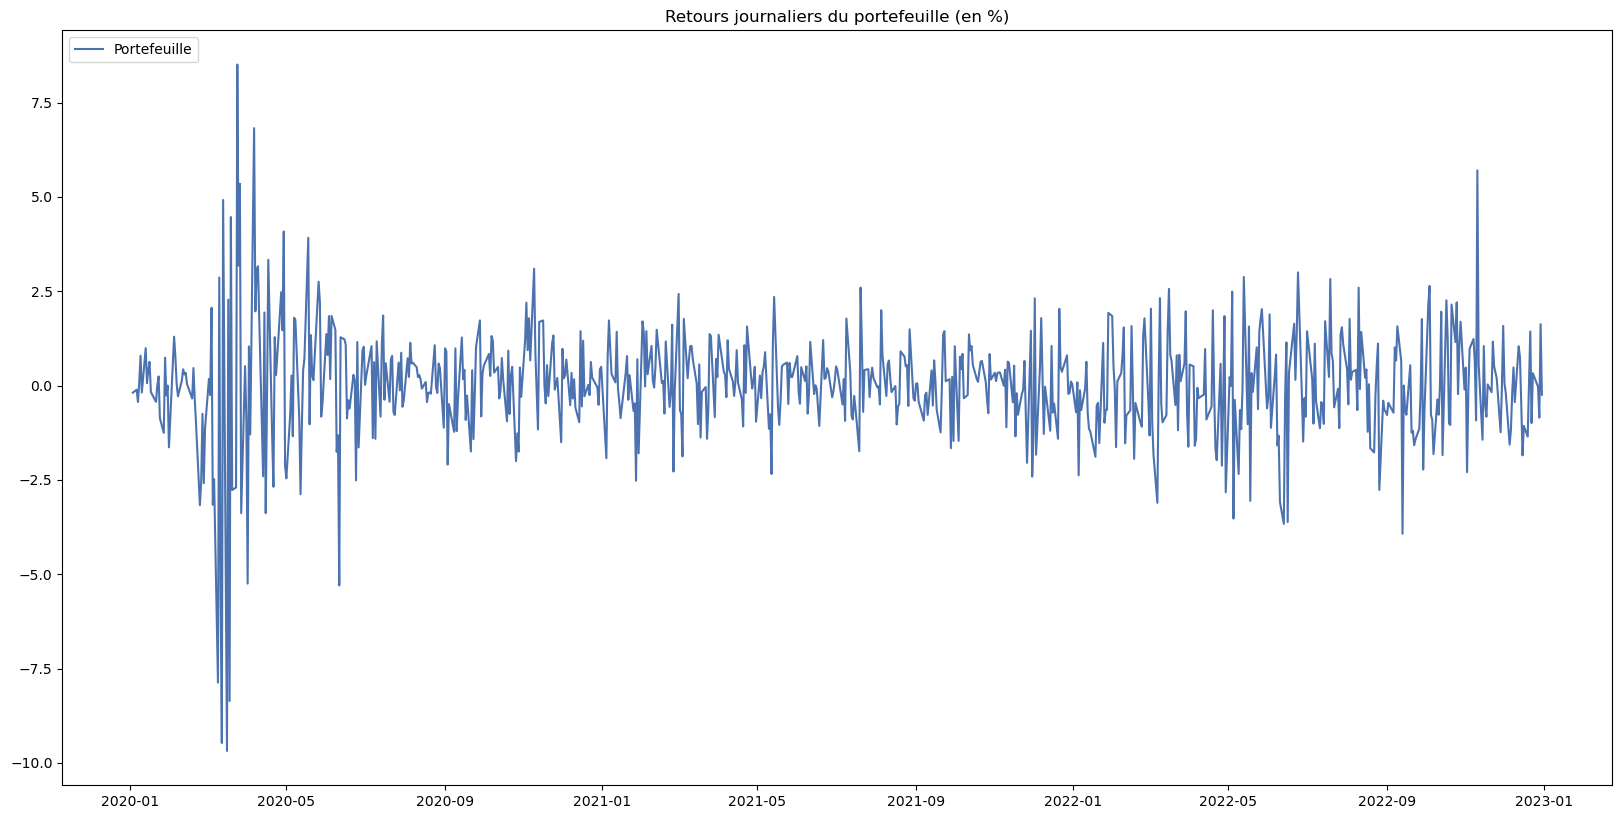

In [25]:
def daily_returns (df):

#Si des poids son définis 
    try :
        weights = optimized_allocation['1'].tolist()
        # on multiplie les prix par les poids pour avoir une valeur unvestie par action
        df_portfolio_prices_weighted = df*weights
        # Forward filling et before filling appliqués pour gérer les trous 
        df_portfolio_prices_weighted = df_portfolio_prices_weighted.fillna(method="ffill")
        df_portfolio_prices_weighted = df_portfolio_prices_weighted.fillna(method="bfill")
        # On somme le montant engagé dans chaque action pour avoir la valeur liquidative du portefeuille
        df_portfolio_daily_value = df_portfolio_prices_weighted.sum(axis=1)
        # retours entre 2 jours 
        df_portfolio_daily_returns= (df_portfolio_daily_value/df_portfolio_daily_value.shift(1) -1)*100
    except :
        # dans le cas d'un benchmark on utilise uniquement les prix entre 2 jours
        df = df.fillna(method="ffill")
        df = df.fillna(method="bfill")
        df_portfolio_daily_value = df.sum(axis=1)
        df_portfolio_daily_returns= (df_portfolio_daily_value/df_portfolio_daily_value.shift(1) -1)*100
    return df_portfolio_daily_returns

#retours journaliers de la stratégie 
df_portfolio_daily_returns = daily_returns (df = prices)


df_portfolio_daily_returns.to_csv("Retours journaliers du portefeuille")

plt.figure(figsize=(20,10), dpi=100)

# Création du graphique de comparaison des rendements journaliers
plt.plot(df_portfolio_daily_returns, label= "Portefeuille")
plt.legend(loc="upper left")
plt.title("Retours journaliers du portefeuille (en %)")
plt.show()

Date
2020-01-02           NaN
2020-01-03     99.812547
2020-01-06     99.703316
2020-01-07     99.269195
2020-01-08     99.358219
                 ...    
2022-12-23    103.530569
2022-12-27    103.497791
2022-12-28    102.619581
2022-12-29    104.289829
2022-12-30    104.036242
Length: 756, dtype: float64


Text(0.5, 1.0, 'Valorisation du portefeuille')

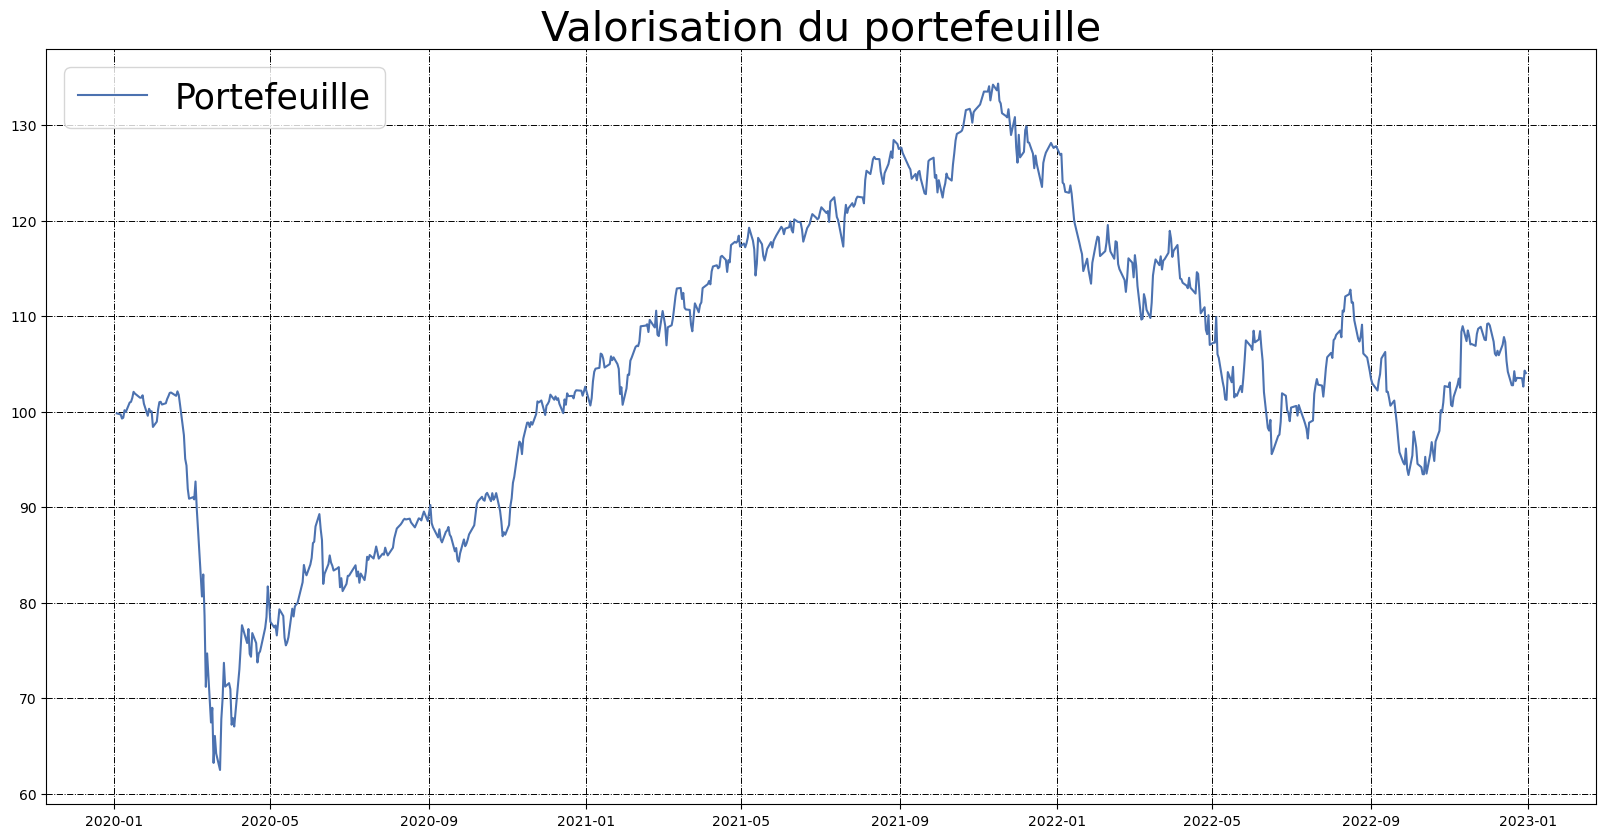

In [26]:
# comparaison de la performance de la stratégie contre l'indice de référence (S&P 500)
start_value = 100

# Calcul de la somme cumulée des retours journaliers
cumulative_returns=((df_portfolio_daily_returns/100)+1).cumprod()*start_value

# Ajout de la valeur cumulée au dataframe
df_portfolio_total_value = cumulative_returns
print(df_portfolio_total_value)
                
# Graphique 
plt.figure(figsize=(20,10), dpi=100)
plt.grid(color='black', linestyle='-.', linewidth=0.7) 
plt.plot(df_portfolio_total_value, label= "Portefeuille")
plt.legend(loc = "upper left", fontsize=25)
plt.title("Valorisation du portefeuille", fontsize=30)

/opt/anaconda3/lib/python3.9/site-packages/pypfopt/risk_models.py:68: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


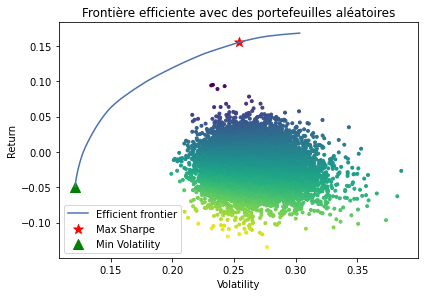

<Figure size 2160x2160 with 0 Axes>

In [27]:
mu = expected_returns.mean_historical_return(prices)
S = risk_models.sample_cov(prices)


# Optimisation du portefeuille à partir de la librairie pypfopt 
ef = EfficientFrontier(mu, S, weight_bounds=(0,0.05))
ef_max_sharpe = EfficientFrontier(mu, S, weight_bounds=(0,0.05))
ef_min_vol = EfficientFrontier(mu, S, weight_bounds=(0,0.05))
# Ajout de contraintes sectorielle et géogrpahique 

ef.add_objective(objective_functions.L2_reg, gamma=0.03)
ef_max_sharpe.add_objective(objective_functions.L2_reg, gamma=0.03)
ef_min_vol.add_objective(objective_functions.L2_reg, gamma=0.03)


fig, ax = plt.subplots()

plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# On cherche pour chacune des optimisations le portefeuille tangeant
ef_max_sharpe.max_sharpe()
ef_min_vol.min_volatility()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")
ret_tangent, std_tangent, _ = ef_min_vol.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="^", s=100, c="g", label="Min Volatility")


# On génère des portefeuilles aléatoires 
n_samples = 15000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Frontière efficiente avec des portefeuilles aléatoires")
ax.legend()
#plt.tight_layout()
plt.figure(figsize=(30,30))
plt.savefig("ef_scatter.png")
plt.show()